In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

# Read and Checking Data

In [26]:
df = pd.read_csv("/content/DOM_hourly.csv")
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116189 entries, 0 to 116188
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  116189 non-null  object 
 1   DOM_MW    116189 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [28]:
# convert the Datetime column to Datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# indexing the Datetime column after the transformation
df.set_index('Datetime', inplace=True)
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [8]:
# hecking missing data
df.isna().sum()

,0
DOM_MW,0


In [29]:
# Let see at the years in the data set
years = df.index.year.unique()
years

Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018],
      dtype='int32', name='Datetime')

In [30]:
# Let's see the average energy consumed per year
df_yearly_avg = df['DOM_MW'].resample('Y').mean()
df_yearly_avg.to_frame()

,DOM_MW
Datetime,
2005-12-31,10833.524668
2006-12-31,10457.146951
2007-12-31,10991.015871
2008-12-31,10786.751765
2009-12-31,10696.930235
2010-12-31,11280.065548
2011-12-31,10865.571021
2012-12-31,10614.735368
2013-12-31,10904.946677


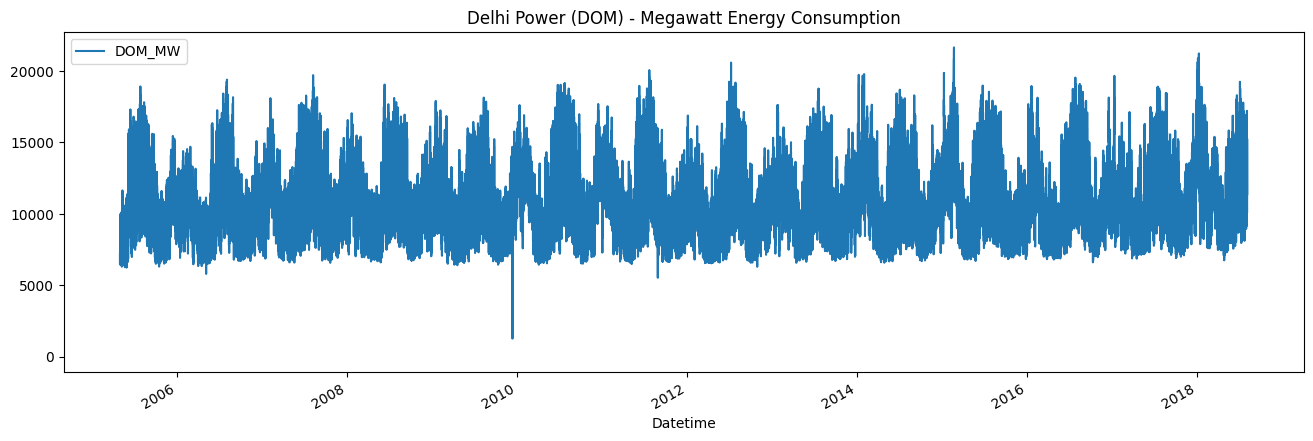

In [31]:
df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Delhi Power (DOM) - Megawatt Energy Consumption')

plt.show()

# Normalisation Process


In [32]:
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    df['DOM_MW'] = normalized_data
    return df, scaler

df_norm, scaler = normalize_data(df)
df_norm.shape

(116189, 1)

In [33]:
df_norm

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263
...,...
2018-01-01 20:00:00,0.841504
2018-01-01 21:00:00,0.848809
2018-01-01 22:00:00,0.836062


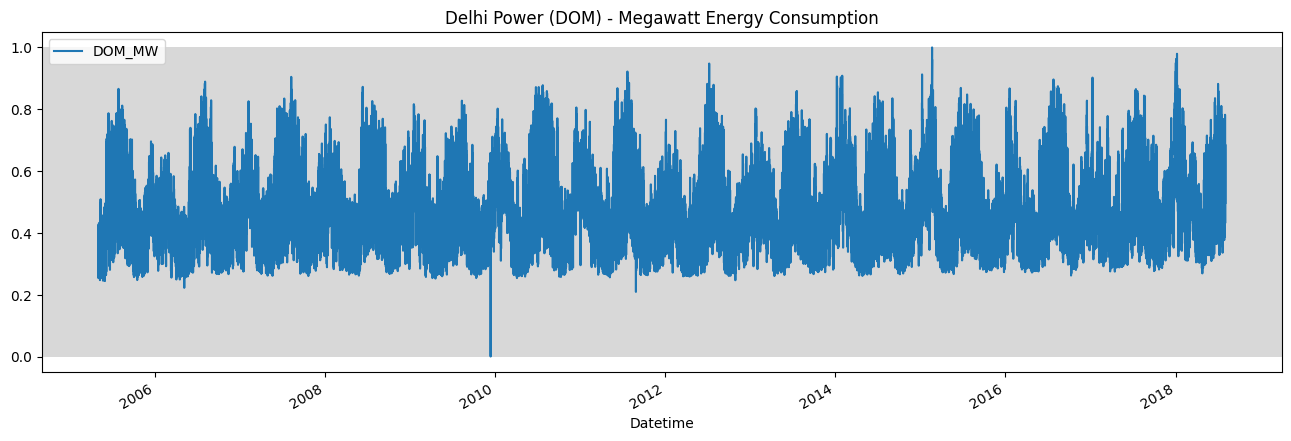

In [34]:
# Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Delhi Power (DOM) - Megawatt Energy Consumption')

plt.show()

In [35]:
# 2017-02-13 after this date we will choose the test set
split_date = '2017-02-13'

DOM_train = df_norm.loc[df_norm.index <= split_date].copy()
DOM_test = df_norm.loc[df_norm.index > split_date].copy()

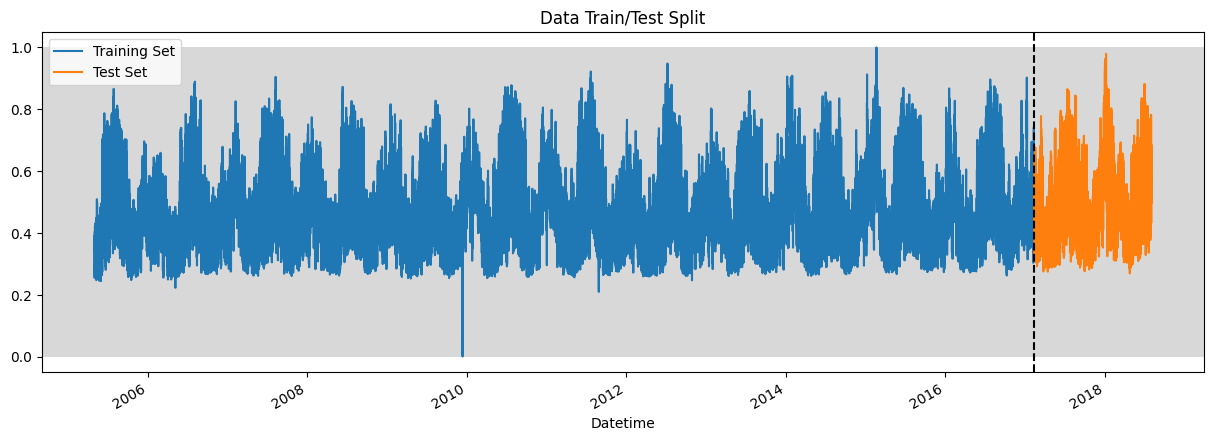

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
DOM_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
DOM_test.plot(ax=ax, label='Test Set')
ax.axvline('2017-02-13', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

# Preparing Data for Rnn and lstm model

In [37]:
def load_data(data, seq_len):
    X_train = []
    y_train = []

    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])

    # last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # reshape data to input into RNN&LSTM models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [38]:
seq_len = 20

# Let's create train, test data
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


# Buliding Rnn model


In [40]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))


rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))


rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_21 (SimpleRNN)            │ (None, 20, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_22 (SimpleRNN)            │ (None, 20, 40)              │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_23 (SimpleRNN)            │ (None, 20, 40)              │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_24 (SimpleRNN)            │ (None, 20, 40)              │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_25 (SimpleRNN)            │ (None, 20, 40)              │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_26 (SimpleRNN)            │ (None, 20, 40)              │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,161 (82.66 KB)

 Trainable params: 21,161 (82.66 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=15, batch_size=1000)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 212ms/step - loss: 0.3104
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - loss: 0.0692
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - loss: 0.0413
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - loss: 0.0281
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 0.0196
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - loss: 0.0146
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - loss: 0.0112
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - loss: 0.0089
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 0.0076
Epoch 10/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - loss: 0.0065
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 0.0058
Epoch 12/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - loss: 0.0051
Epoch 13/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - loss: 0.0047
Epoch 14/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 0.0043
Epoch 15/15
110

In [42]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
R2 Score of RNN model =  0.8460457865669619


In [43]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
rnn_predictions_inverse = rnn_predictions_inverse.flatten()

In [45]:
last_6169_index_dates = df.index[-6169:]

# Now let's see our actual y and predicted y values as dataframes
results_RNN = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions_inverse})
results_RNN

,Date,Actual,Predicted
0,2017-02-13 23:00:00,11494.0,10477.802734
1,2017-02-14 00:00:00,10975.0,10107.285156
2,2017-02-12 01:00:00,8728.0,9821.012695
3,2017-02-12 02:00:00,8390.0,9485.917969
4,2017-02-12 03:00:00,8283.0,8909.759766
...,...,...,...
6164,2018-01-01 20:00:00,18418.0,16053.599609
6165,2018-01-01 21:00:00,18567.0,16296.368164
6166,2018-01-01 22:00:00,18307.0,16557.373047
6167,2018-01-01 23:00:00,17814.0,16709.371094


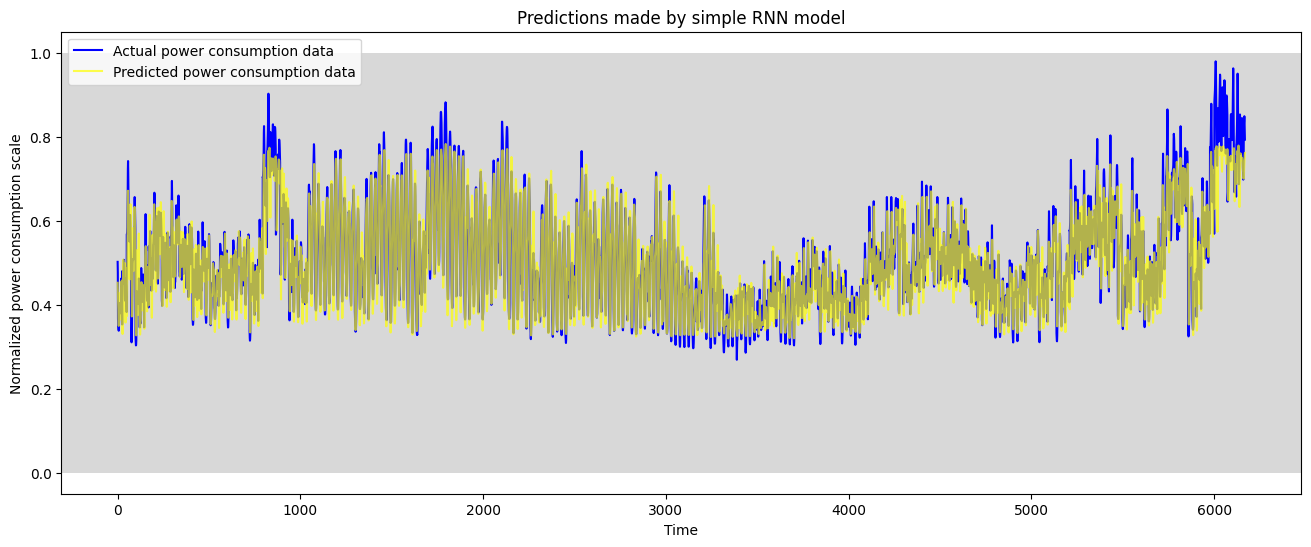

In [46]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# Buliding Lstm model


In [47]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))


lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))



lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 40)              │           6,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 20, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 20, 40)              │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 175,241 (684.54 KB)

 Trainable params: 175,241 (684.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - loss: 0.0562
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 0.0153
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0146
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.0109
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 0.0104
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 0.0102
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - loss: 0.0098
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.0096
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 0.0094
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.0093
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 0.0091
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0090
Epoch 13/30
 46/110 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - loss: 0.0087

In [48]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step
R^2 Score of LSTM model =  0.8753993579868387


In [41]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
lstm_predictions_inverse = lstm_predictions_inverse.flatten()

In [42]:
# Now let's see our actual y and predicted y values as dataframes
results_LSTM = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})
results_LSTM

,Date,Actual,Predicted
0,2017-02-13 23:00:00,11494.0,10665.042969
1,2017-02-14 00:00:00,10975.0,9931.713867
2,2017-02-12 01:00:00,8728.0,9435.793945
3,2017-02-12 02:00:00,8390.0,9003.647461
4,2017-02-12 03:00:00,8283.0,8655.336914
...,...,...,...
6164,2018-01-01 20:00:00,18418.0,17745.923828
6165,2018-01-01 21:00:00,18567.0,17810.376953
6166,2018-01-01 22:00:00,18307.0,17886.033203
6167,2018-01-01 23:00:00,17814.0,17716.451172


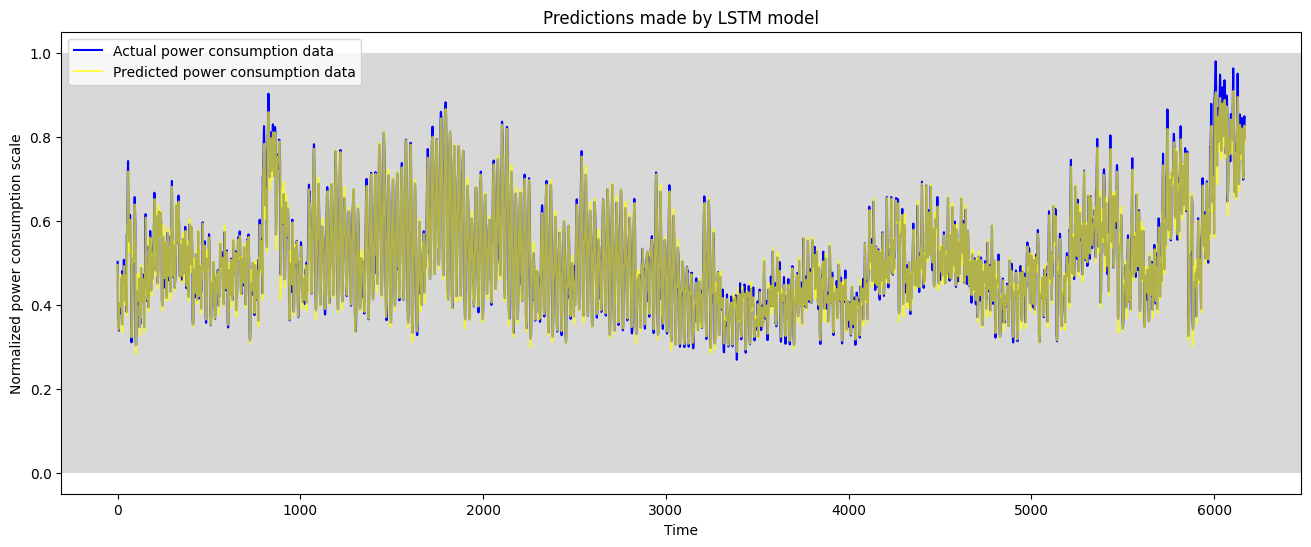

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# Comparing Predicted Values

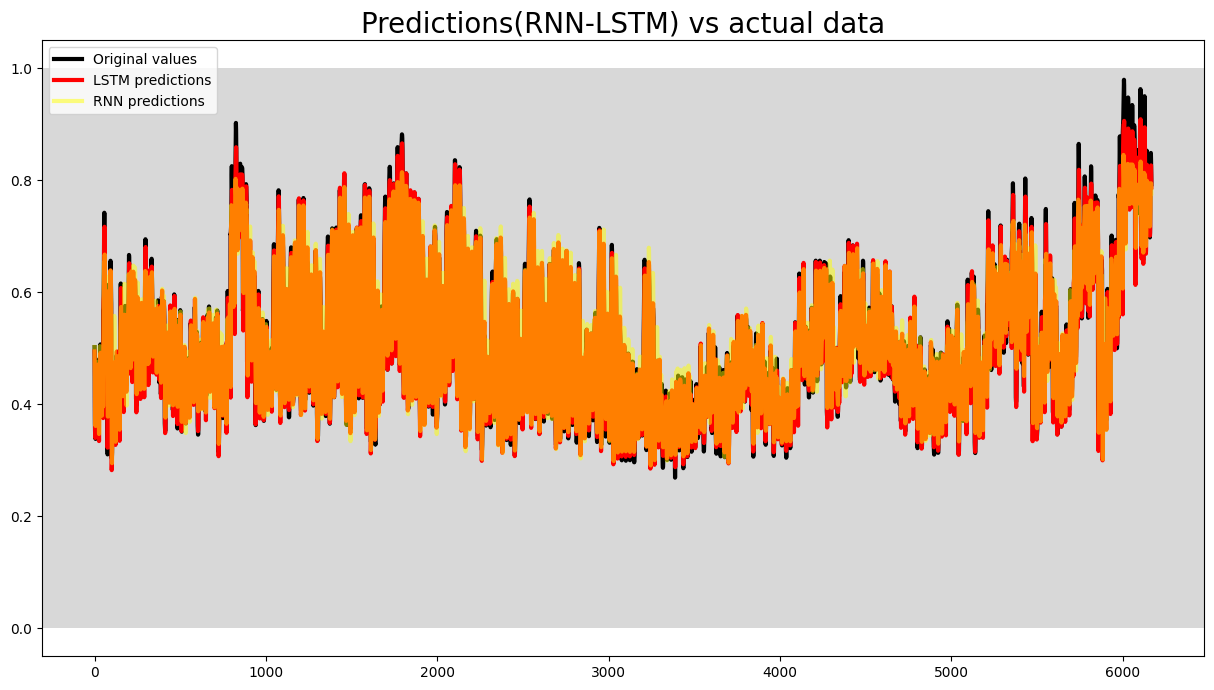

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="black", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="yellow", linewidth=3, label="RNN predictions")
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.legend()
plt.title("Predictions(RNN-LSTM) vs actual data", fontsize=20)
plt.show()